In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration
from sklearn.preprocessing import MinMaxScaler
import scipy
import time
import multiprocessing
from py_vollib.black_scholes.implied_volatility import implied_volatility

## Define some Variables

In [120]:
num_model_parameters = 3
num_strikes = 8
num_maturities = 8


num_input_parameters = 3
num_output_parameters = num_maturities*num_strikes
learning_rate = 0.0001
num_steps = 5
batch_size = 10
num_neurons = 40

#initial values
S0 = 1.0
V0 = 0.3
r = 0.01


contract_bounds = np.array([[0.8*S0,1.2*S0],[5,10]]) #bounds for K,T
model_bounds = np.array([[0.5,2],[0.2,0.8],[-1,0]]) #bounds for alpha,beta,rho, make sure alpha>0, beta,rho \in [0,1]

"""
Note: The grid of stirkes and maturities is equidistant here put could be choosen differently for real world application.
Note: For the code below to striktly follow the bounds specified above make sure that *_distance x num_* is less than half the distance from the highest to lowest * (* = strikes/maturities). 
"""
maturities_distance = (contract_bounds[1,1]-contract_bounds[1,0])/(2*num_maturities) 
strikes_distance = (contract_bounds[0,1]-contract_bounds[0,0])/(2*num_strikes)

strikes = np.linspace(contract_bounds[0,0],contract_bounds[0,0]+num_strikes*strikes_distance,num_strikes)
maturities = np.linspace(contract_bounds[1,0],contract_bounds[1,0]+num_maturities*maturities_distance,num_maturities)

In [121]:
X = tf.placeholder(tf.float32, [None, num_input_parameters])
y = tf.placeholder(tf.float32, [None, num_output_parameters])

## Some Helper Functions

In [129]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

def sabr(alpha,beta,T,W,Z,V0,S0):
    
    #assert(beta>0 and beta<1)

    #def mu2(V,i,k):
    #    return 0.0
    
    #def sigma2(V,i,k):
    #    return np.multiply(alpha,V)
    
    #V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def V(i,k):
        n = W.shape[1]-1
        t = k*T/n
        return V0*np.exp(-alpha*alpha/2*t+alpha*Z[i,k])

    def mu1(S,i,k):
        return np.multiply(r,S)
    
    def sigma1(S,i,k):
        return np.multiply(V(i,k),np.power(np.maximum(0.0,S),beta))
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

def reverse_transform_X(X_scaled):
    X = np.zeros(X_scaled.shape)
    for i in range(num_input_parameters):
        X[:,i] = X_scaled[:,i]*(model_bounds[i][1]-model_bounds[i][0]) + model_bounds[i][0]
    return X

def price_pred(alpha,beta,rho,n,dim,T,K,V0,S0):
    W,Z = corr_brownian_motion(n,T,dim,rho)
    S,V = sabr(alpha,beta,T,W,Z,V0,S0)
    S_T = S[:,n]
    P = np.exp(-r*T) * np.mean(np.maximum(S_T-K,np.zeros(dim)))
    
    return P

def implied_vol(P,K,T):
    if not P<S0:
        print("P<S0= ",P<S0,", abitrage!")
        return 0.0
    if not P>S0-K*np.exp(-r*T):
        print("P>S0-K*np.exp(-r*T)= ",P>S0-K*np.exp(-r*T),", abitrage!")
        return 0.0
    def f(sigma):
        dplus = (np.log(S0 / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        dminus = (np.log(S0 / K) + (r  - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        
        return S0 * norm.cdf(dplus, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(dminus, 0.0, 1.0) - P
     
    #return scipy.optimize.brentq(f, 0, 100000)
    return implied_volatility(P, S0, K, T, r, 'c')

def BS_call_price(sigma,K,T):
    dplus = (np.log(S0 / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    dminus = (np.log(S0 / K) + (r  - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    return S0 * norm.cdf(dplus, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(dminus, 0.0, 1.0)


def next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds):
    X_scaled = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))

    X_scaled[:,0] = uniform.rvs(size=batch_size) #alpha
    X_scaled[:,1] = uniform.rvs(size=batch_size) #beta
    X_scaled[:,2] = uniform.rvs(size=batch_size) #rho

    X = reverse_transform_X(X_scaled)

    n = 100
    dim = 10000
    for i in range(batch_size):
        W,Z = corr_brownian_motion(n,maturities[-1],dim,X[i,2])
        S,V = sabr(X[i,0],X[i,1],maturities[-1],W,Z,V0,S0)
        
        for j in range(num_maturities):
            n_current = int(maturities[j]/maturities[-1]*n)
            S_T = S[:,n_current]
            
            for k in range(num_strikes):
                P = np.mean(np.maximum(S_T-np.ones(dim)*strikes[k],np.zeros(dim)))*np.exp(-r*maturities[j])
                
                y[i,j*num_strikes+k] = implied_vol(P,strikes[k],maturities[j])

                #y[i,j*num_strikes+k] = np.exp(-r*maturities[j])*np.mean(np.maximum(S_T-np.ones(dim)*strikes[k],np.zeros(dim)))
    return X_scaled,y

In [131]:
next_batch_sabr_EM_train(1,contract_bounds,model_bounds)

(array([[0.6687964 , 0.79266535, 0.07636311]]),
 array([[0.13831904, 0.12921636, 0.12016338, 0.11117405, 0.10218903,
         0.09312564, 0.08393111, 0.07456378, 0.13581617, 0.12698094,
         0.11819081, 0.1094692 , 0.10075326, 0.09199276, 0.0830972 ,
         0.07403483, 0.13340194, 0.12479445, 0.11626504, 0.10778217,
         0.09931556, 0.09077405, 0.08216723, 0.0733825 , 0.12973984,
         0.1214818 , 0.11329847, 0.10512541, 0.09697519, 0.08876675,
         0.08048133, 0.0720281 , 0.12756414, 0.11952226, 0.11154777,
         0.10359582, 0.0956689 , 0.0876914 , 0.07963259, 0.07144782,
         0.12549428, 0.11767417, 0.10992945, 0.10220015, 0.09448043,
         0.08671882, 0.07887681, 0.07091807, 0.12362306, 0.1159778 ,
         0.10840619, 0.10087603, 0.09336198, 0.08580192, 0.07816421,
         0.07040782, 0.12198394, 0.11451515, 0.10710859, 0.09972577,
         0.09237502, 0.08500692, 0.07756773, 0.07000509]]))

In [94]:
sigmaa = implied_vol(0.5,0.6,3)
print(sigmaa)
prizz = BS_call_price(sigmaa,0.6,3)
print(prizz)

0.44996812403170117
0.5


## Design of the NN

In [6]:
#Layers
hidden1 = fully_connected(X, num_neurons, activation_fn=tf.nn.elu)
bn1 = tf.nn.batch_normalization(hidden1, 0, 1, 0, 1, 0.000001)
hidden2 = fully_connected(bn1, num_neurons, activation_fn=tf.nn.elu)
bn2 = tf.nn.batch_normalization(hidden2, 0, 1, 0, 1, 0.000001)
hidden3 = fully_connected(bn2, num_neurons, activation_fn=tf.nn.elu)
bn3 = tf.nn.batch_normalization(hidden3, 0, 1, 0, 1, 0.000001)
hidden4 = fully_connected(hidden3, num_neurons, activation_fn=tf.nn.elu)
bn4 = tf.nn.batch_normalization(hidden4, 0, 1, 0, 1, 0.000001)

outputs = fully_connected(bn4, num_output_parameters, activation_fn=None)

Instructions for updating:
Please use `layer.__call__` method instead.


In [7]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [383]:
num_cpu = multiprocessing.cpu_count()
config = tf.ConfigProto(device_count={ "CPU": num_cpu },
                                        inter_op_parallelism_threads=num_cpu,
                                        intra_op_parallelism_threads=2,
                                        )

with tf.Session(config=config) as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        
        X_batch,Y_batch = next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds)
        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        if iteration % 1 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
    
    saver.save(sess, "./models/sabr_dnn")

KeyboardInterrupt: 

## More Helper Functions
### Note: You can choose which trained weights to use below

In [11]:
def prices_grid(theta):
    prices_true = np.zeros((1,num_output_parameters))
    n = 100
    dim = 10000
    W,Z = corr_brownian_motion(n,maturities[-1],dim,theta[2])
    S,V = sabr(theta[0],theta[1],maturities[-1],W,Z,V0,S0)
    
    for i in range(num_maturities):
        n_current = int(maturities[i]/maturities[-1]*n)
        S_T = S[:,n_current]
        for j in range(num_strikes):        
            prices_true[0,i*num_strikes+j] = np.exp(-r*maturities[i])*np.mean(np.maximum(S_T-np.ones(dim)*strikes[j],np.zeros(dim)))
    return prices_true

In [123]:
def predict_theta(prices_true):   
    
    def NNprediction(theta):
        x = np.zeros((1,len(theta)))
        x[0,:] = theta
        return sess.run(outputs,feed_dict={X: x})
    def NNgradientpred(x):
        x = np.asarray(x)
        grad = np.zeros((num_output_parameters,num_input_parameters))
        
        delta = 0.0000000001
        for i in range(num_input_parameters):
            h = np.zeros(x.shape)
            h[0,i] = delta
            
            #two point gradient
            #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

            #four point gradient
            grad[:,i] = (-sess.run(outputs,feed_dict={X: x+2*h})+8*sess.run(outputs,feed_dict={X: x+h})-8*sess.run(outputs,feed_dict={X: x-h}) +sess.run(outputs,feed_dict={X: x-2*h}))/12/delta

        return np.mean(grad,axis=0)

    def CostFuncLS(theta):
        
        return np.sqrt(np.mean(np.power((NNprediction(theta)-prices_true.flatten())[0],2),axis=0))


    def JacobianLS(theta):
        x = np.zeros((1,len(theta)))
        x[0,:] = theta
        return NNgradientpred(x).T

    with tf.Session() as sess:                          
        saver.restore(sess, "./models/sabr_dnn")  
        #saver.restore(sess, "./models/sabr_dnn_e")    
        
        init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
        bnds = ([model_bounds[0,0],model_bounds[1,0],model_bounds[2,0]],[model_bounds[0,1],model_bounds[1,1],model_bounds[2,1]])

        
        I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,bounds=bnds,gtol=1E-15,tr_solver='exact',xtol=1E-15,ftol=1E-15,verbose=1)

    theta_pred = I.x
  
    return theta_pred

## Predict and Plot for one specific theta_true

In [9]:
theta_true = [0.1,0.5,-0.5]
prices_true = prices_grid(theta_true)

In [127]:
theta_pred = predict_theta(prices_true)

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 4.0584e-03, final cost 4.0584e-03, first-order optimality 1.99e-02.


In [120]:
print(theta_true)
print(theta_pred)

[0.1, 0.5, -0.5]
[ 0.03558846  0.19237739 -0.89294346]


In [ ]:
prices_true = np.zeros((num_maturities,num_strikes))
prices_pred = np.zeros((num_maturities,num_strikes))
init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
prices_trash = np.zeros((num_maturities,num_strikes))
n = 100
dim = 300
for i in range(num_maturities):
    for j in range(num_strikes):        
        prices_true[i,j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_pred[i,j] = price_pred(theta_pred[0],theta_pred[1],theta_pred[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_trash[i,j] = price_pred(init[0],init[1],init[2],n,dim,maturities[i],strikes[j],V0,S0)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(20, 9))

T_ = np.zeros((num_maturities,num_strikes))
K_ = np.zeros((num_maturities,num_strikes))
for i in range(num_strikes):
    for j in range(num_maturities):
        T_[j,i] = maturities[j]
for j in range(num_maturities):   
    for i in range(num_strikes):
        K_[j,i] = strikes[i]

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X=K_, Y=T_, Z=prices_true, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')
ax1.set_title('True Prices')
ax1.view_init(15, 45)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=prices_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices (Method 1)')
ax2.view_init(15, 45)


ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=prices_true-prices_pred, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity')
ax3.set_zlabel('Price Diff')
ax3.set_title('Difference')
ax3.view_init(5, 45)
"""
ax3 = fig.add_subplot(133)
ax3.imshow(prices_true-prices_pred,cmap='Blues_r')
ax3.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax3.set_xticklabels(np.around(strikes,decimals=1))
ax3.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax3.set_yticklabels(np.around(maturities,decimals=1))
"""
plt.savefig('prices_dnn.pdf') 
plt.show()


In [ ]:
mean_err = np.mean(np.mean(np.abs(prices_true-prices_pred),axis=0),axis=0)
mean_err_init = np.mean(np.mean(np.abs(prices_true-prices_trash),axis=0),axis=0)
mean_true_price = np.mean(np.mean(np.abs(prices_true),axis=0),axis=0)
print("MSE: ",mean_err)
print("MSE Init: ",mean_err_init)
print("Percent of avg True Price: ",mean_err/mean_true_price)

### Create Grid of Model Parameters and corresponding Prices

In [ ]:
bb = 2
num_thetas = np.power(bb,num_model_parameters)
thetas_true = np.zeros((num_thetas,num_model_parameters))

for i in range(bb):
    for j in range(bb):
        for k in range(bb):
            thetas_true[i*bb*bb+j*bb+k,0] = model_bounds[0,0]+ k *(model_bounds[0,1]-model_bounds[0,0])/(bb-1)
            thetas_true[i*bb*bb+j*bb+k,1] = model_bounds[1,0]+ j *(model_bounds[1,1]-model_bounds[1,0])/(bb-1)
            thetas_true[i*bb*bb+j*bb+k,2] = model_bounds[2,0]+ i *(model_bounds[2,1]-model_bounds[2,0])/(bb-1)


In [ ]:
thetas_pred = np.zeros((num_thetas,num_model_parameters))
for i in range(num_thetas):
    thetas_pred[i,:] = predict_theta(prices_grid(thetas_true[i,:]).flatten())

In [ ]:
diff = np.mean(np.mean(np.power(thetas_pred - thetas_true,2),axis=0),axis=0)
print(thetas_true)
print(np.around(thetas_pred,5))

In [ ]:
rel_error = np.mean(np.abs(thetas_pred - thetas_true),axis=1)/np.abs(np.mean(thetas_true,axis=1))
print("Relative Error: ",  rel_error )

In [ ]:
prices_grid_true = np.zeros((num_thetas,num_maturities,num_strikes))
prices_grid_pred = np.zeros((num_thetas,num_maturities,num_strikes))
n = 100
dim = 100
for i in range(num_thetas):
    for j in range(num_maturities):
        for k in range(num_strikes):
            prices_grid_true[i,j,k] = price_pred(thetas_true[i,0],thetas_true[i,1],thetas_true[i,2],n,dim,maturities[i],strikes[j],V0,S0)
            prices_grid_pred[i,j,k] = price_pred(thetas_pred[i,0],thetas_pred[i,1],thetas_pred[i,2],n,dim,maturities[i],strikes[j],V0,S0)

In [ ]:
fig = plt.figure(figsize=(9, 6))

ax=plt.subplot(1,1,1)

plt.imshow(np.mean(np.abs((prices_grid_true-prices_grid_pred)/prices_grid_true),axis=0))
plt.title("Average Relative Errors in Prices")

ax.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax.set_yticklabels(np.around(maturities,1))
ax.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax.set_xticklabels(np.around(strikes,2))


plt.colorbar()

plt.show()

In [56]:
N = 10

thetas_true_rand = reverse_transform_X(uniform.rvs(size=(N,num_model_parameters)))

In [57]:
thetas_pred_rand = np.zeros((N,num_model_parameters))
for i in range(N):
    thetas_pred_rand[i,:] = predict_theta(prices_grid(thetas_true_rand[i,:]).flatten())

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 26, initial cost 9.3160e-03, final cost 9.3160e-03, first-order optimality 1.83e-03.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 9.1198e-03, final cost 5.0145e-03, first-order optimality 1.41e-02.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 7.8589e-03, final cost 7.8589e-03, first-order optimality 1.35e-02.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 25, initial cost 8.3294e-03, final cost 8.3294e-03, first-order optimality 1.45e-03.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 25, initial cost 1.1984e-02, final cost 

In [58]:
rel_error_rand = np.mean(np.abs(thetas_pred_rand - thetas_true_rand),axis=1)/np.abs(np.mean(thetas_true_rand,axis=1))
print("Relative Error: ",  rel_error_rand )

Relative Error:  [ 0.79659606  2.18507599  2.85105208  0.93721497  1.04846179  0.74343967
  1.36184868  0.58499164 14.28484028  2.68906175]


In [59]:
prices_grid_true_2 = np.zeros((N,num_maturities,num_strikes))
prices_grid_pred_2 = np.zeros((N,num_maturities,num_strikes))
n = 100
dim = 100
for i in range(N):
    for j in range(num_maturities):
        for k in range(num_strikes):
            prices_grid_true_2[i,j,k] = price_pred(thetas_true_rand[i,0],thetas_true_rand[i,1],thetas_true_rand[i,2],n,dim,maturities[i],strikes[j],V0,S0)
            prices_grid_pred_2[i,j,k] = price_pred(thetas_pred_rand[i,0],thetas_pred_rand[i,1],thetas_pred_rand[i,2],n,dim,maturities[i],strikes[j],V0,S0)

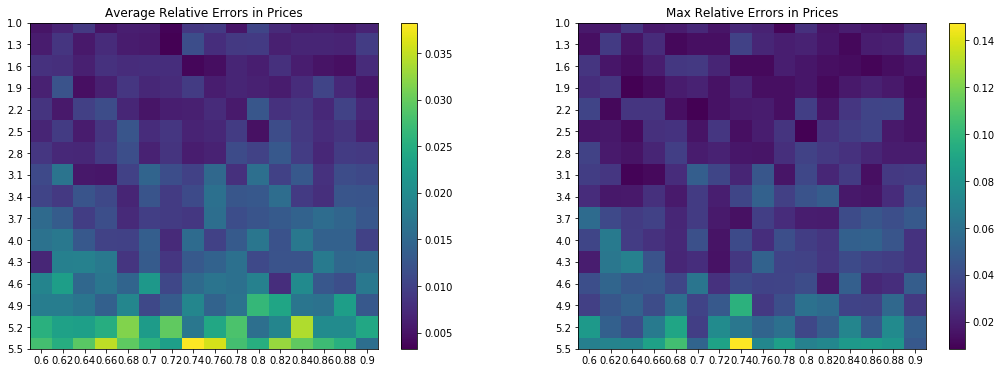

In [60]:
fig = plt.figure(figsize=(18, 6))

ax1=fig.add_subplot(121)

plt.imshow(np.mean(np.abs((prices_grid_true_2-prices_grid_pred_2)/prices_grid_true_2),axis=0))
plt.title("Average Relative Errors in Prices")

ax1.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax1.set_yticklabels(np.around(maturities,1))
ax1.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax1.set_xticklabels(np.around(strikes,2))
plt.colorbar()
ax2=fig.add_subplot(122)

plt.imshow(np.max(np.abs((prices_grid_true_2-prices_grid_pred_2)/prices_grid_true_2),axis=0))
plt.title("Max Relative Errors in Prices")

ax2.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax2.set_yticklabels(np.around(maturities,1))
ax2.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax2.set_xticklabels(np.around(strikes,2))


plt.colorbar()
plt.savefig('errors_dnn_m1_e.pdf') 
plt.show()


In [115]:
2000**(2/3)

158.7401051968199

In [13]:
with tf.Session() as sess:                          
        saver.restore(sess, "./models/sabr_dnn")
        x = uniform.rvs(size=(1,3))
        %timeit sess.run(outputs,feed_dict={X: x})

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
173 µs ± 2.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
theta= reverse_transform_X(uniform.rvs(size=(1,num_model_parameters)))

%timeit prices_grid(theta[0,:])

15.2 s ± 73.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit corr_brownian_motion(100,1,10000,0)

77.5 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
W,Z=corr_brownian_motion(100,1,10000,0)
%timeit sabr(theta[0,0],theta[0,1],maturities[-1],W,Z,V0,S0)

15.3 s ± 288 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit next_batch_sabr_EM_train(1,contract_bounds,model_bounds)

15.4 s ± 77.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
def NNgradientpred(x):
    x = np.asarray(x)
    grad = np.zeros((num_output_parameters,num_input_parameters))
        
    delta = 0.0000000001
    for i in range(num_input_parameters):
        h = np.zeros(x.shape)
        h[0,i] = delta
        
        #two point gradient
        #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

        #four point gradient
        grad[:,i] = (-sess.run(outputs,feed_dict={X: x+2*h})+8*sess.run(outputs,feed_dict={X: x+h})-8*sess.run(outputs,feed_dict={X: x-h}) +sess.run(outputs,feed_dict={X: x-2*h}))/12/delta

    return np.mean(grad,axis=0)

with tf.Session() as sess:                          
        saver.restore(sess, "./models/sabr_dnn")
        theta = uniform.rvs(size=(1,3))
        x = np.zeros((1,3))
        
        x[0,:] = theta
        %timeit NNgradientpred(x).T

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
2.5 ms ± 71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
